# Studium Parisiense — EDA Notebook (Data Exploration & Consistency Checks)

- dataset size & basic stats  
- coverage (which sections/fields exist and how often)  
- schema exploration (field paths + type variability)  
- text characteristics (length outliers, markup patterns)  
- inconsistency detection (duplicates, malformed dates, invalid structures)  
- exports of EDA reports as CSV for your project documentation

## 0) Setup

In [5]:
import os
import json
import math
import re
from collections import Counter, defaultdict
from typing import Any, Dict, Iterator, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

pd.set_option("display.max_colwidth", 160)

## 1) Configuration

- **INPUT_JSONL**: path to your dataset (`.jsonl`)
- **OUTPUT_DIR**: where we write EDA reports (CSV)
- **SAMPLE_N**: if set, processes only the first N records (faster for iteration)

In [6]:
# --- PATHS ---
INPUT_JSONL = "studium_parisiense_dataset.jsonl"  # change if needed
# If you run this notebook elsewhere, provide the full path, e.g. "/path/to/studium_dataset.jsonl"

OUTPUT_DIR = "eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- PERFORMANCE SWITCH ---
# Use SAMPLE_N for quick iteration; set to None for the full dataset.
SAMPLE_N: Optional[int] = None  # e.g. 500, 2000, or None

# --- DOMAIN EXPECTATIONS (useful for anomaly checks) ---
EXPECTED_YEAR_MIN = 1100
EXPECTED_YEAR_MAX = 1600

print("INPUT_JSONL:", INPUT_JSONL)
print("OUTPUT_DIR:", OUTPUT_DIR)

INPUT_JSONL: studium_parisiense_dataset.jsonl
OUTPUT_DIR: eda_outputs


## 2) Utilities (JSONL streaming + schema traversal)

In [7]:
def iter_jsonl(path: str, sample_n: Optional[int] = None) -> Iterator[Dict[str, Any]]:
    # Stream JSONL records safely.
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if sample_n is not None and i >= sample_n:
                break
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except json.JSONDecodeError:
                continue


def count_lines(path: str) -> int:
    n = 0
    with open(path, "r", encoding="utf-8") as f:
        for n, _ in enumerate(f, start=1):
            pass
    return n


def flatten_leaf_paths(obj: Any, prefix: str = "") -> Iterator[Tuple[str, str]]:
    # Yield (path, type_name) for leaf nodes. Lists are represented with [].
    if isinstance(obj, dict):
        for k, v in obj.items():
            new_prefix = f"{prefix}.{k}" if prefix else k
            yield from flatten_leaf_paths(v, new_prefix)
    elif isinstance(obj, list):
        new_prefix = f"{prefix}[]"
        if not obj:
            yield (new_prefix, "empty_list")
        else:
            for item in obj:
                yield from flatten_leaf_paths(item, new_prefix)
    else:
        yield (prefix, type(obj).__name__)


def flatten_all_paths(obj: Any, prefix: str = "") -> Iterator[Tuple[str, str]]:
    # Yield (path, node_type) for every node including intermediate dict/list nodes.
    if isinstance(obj, dict):
        if prefix:
            yield (prefix, "dict")
        for k, v in obj.items():
            new_prefix = f"{prefix}.{k}" if prefix else k
            yield from flatten_all_paths(v, new_prefix)
    elif isinstance(obj, list):
        list_path = f"{prefix}[]"
        yield (list_path, "list")
        for item in obj:
            yield from flatten_all_paths(item, list_path)
    else:
        if prefix:
            yield (prefix, type(obj).__name__)


def get_first_name(rec: Dict[str, Any]) -> Optional[str]:
    # Extract the first identity.name[].value if present.
    try:
        name_entries = rec.get("identity", {}).get("name", [])
        if isinstance(name_entries, list) and name_entries:
            if isinstance(name_entries[0], dict):
                return name_entries[0].get("value")
    except Exception:
        pass
    return None


def normalize_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", text).strip()


# Markup patterns often present in Studium strings
PERCENT_BLOCK = re.compile(r"%([^%]+)%")
DOLLAR_BLOCK = re.compile(r"\$([^$]+)\$")
AMP_BLOCK = re.compile(r"&([^&]+)&")
HTML_TAG = re.compile(r"<[^>]+>")

def strip_studium_markup(s: str) -> str:
    # Conservative markup stripping: keeps inner content.
    s = HTML_TAG.sub("", s)
    s = PERCENT_BLOCK.sub(r"\1", s)
    s = DOLLAR_BLOCK.sub(r"\1", s)
    s = AMP_BLOCK.sub(r"\1", s)
    return normalize_whitespace(s)

## 3) Load dataset (count + quick sanity checks)

In [8]:
total_lines = count_lines(INPUT_JSONL)
print("Total lines in file:", total_lines)

records_seen = 0
for _ in iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N):
    records_seen += 1

print("Records parsed:", records_seen, "(SAMPLE_N=" + str(SAMPLE_N) + ")")

FileNotFoundError: [Errno 2] No such file or directory: 'studium_parisiense_dataset.jsonl'

## 4) Dataset overview (top-level structure & coverage)

We compute:
- top-level keys frequency (coverage)
- types for each top-level key (schema stability)

In [ ]:
top_presence = Counter()
top_type_dist = defaultdict(Counter)
n = 0

for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Scanning"):
    n += 1
    for k, v in rec.items():
        top_presence[k] += 1
        top_type_dist[k][type(v).__name__] += 1

coverage_df = (
    pd.DataFrame({
        "key": list(top_presence.keys()),
        "count": [top_presence[k] for k in top_presence],
        "coverage": [top_presence[k] / n for k in top_presence],
        "types": [dict(top_type_dist[k]) for k in top_presence],
    })
    .sort_values("coverage", ascending=False)
    .reset_index(drop=True)
)

coverage_df

Scanning:   0%|          | 0/20149 [00:00<?, ?it/s]

,key,count,coverage,types
0,_id,20149,1.000000,{'str': 20149}
1,identity,20149,1.000000,{'dict': 20149}
2,title,20149,1.000000,{'str': 20149}
3,link,20149,1.000000,{'str': 20149}
4,extras,20149,1.000000,{'dict': 20149}
5,raw,20149,1.000000,{'list': 20149}
6,reference,20149,1.000000,{'str': 20149}
7,bibliography,20127,0.998908,{'dict': 20127}
8,curriculum,19614,0.973448,{'dict': 19614}
9,origin,11193,0.555511,{'dict': 11193}


### Plot: coverage of top-level keys

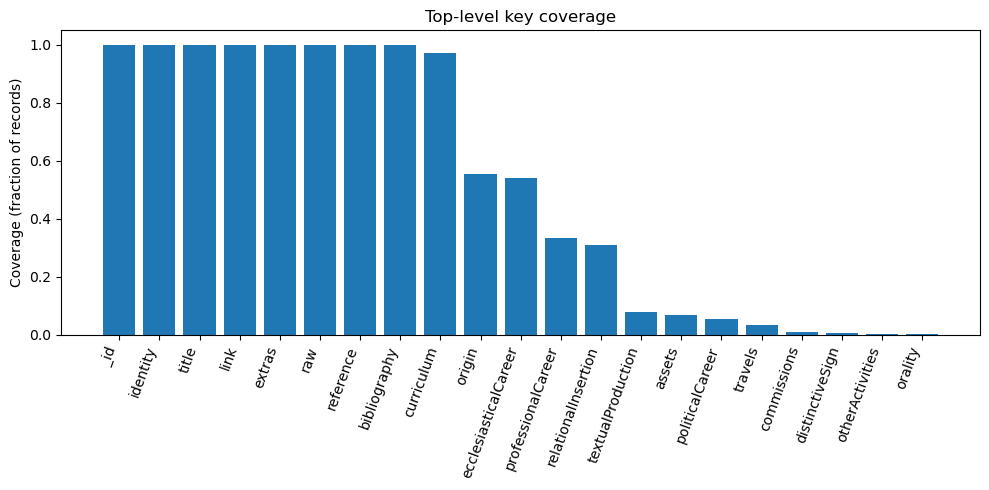

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(coverage_df["key"], coverage_df["coverage"])
plt.xticks(rotation=70, ha="right")
plt.ylabel("Coverage (fraction of records)")
plt.title("Top-level key coverage")
plt.tight_layout()
plt.show()

### Export: top-level coverage report

In [ ]:
top_level_csv = os.path.join(OUTPUT_DIR, "top_level_key_coverage.csv")
coverage_df.to_csv(top_level_csv, index=False)
print("Wrote:", top_level_csv)

Wrote: eda_outputs\top_level_key_coverage.csv


## 5) Build a lightweight “index” DataFrame

We extract:
- `reference`, `name`, `link`, `title`
- `activityMediane` (from `extras` if present)
- per-section presence (binary columns)

In [ ]:
sections = [
    "identity","curriculum","bibliography","origin","ecclesiasticalCareer","professionalCareer",
    "relationalInsertion","textualProduction","assets","politicalCareer","travels","commissions",
    "orality","distinctiveSign","otherActivities"
]

rows = []
for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Indexing"):
    rows.append({
        "reference": rec.get("reference"),
        "name": get_first_name(rec),
        "title": rec.get("title"),
        "link": rec.get("link"),
        "activityMediane": rec.get("extras", {}).get("activityMediane"),
        **{f"has_{s}": int(s in rec) for s in sections}
    })

index_df = pd.DataFrame(rows)
index_df.head()

Indexing:   0%|          | 0/20149 [00:00<?, ?it/s]

,reference,name,title,link,activityMediane,has_identity,has_curriculum,has_bibliography,has_origin,has_ecclesiasticalCareer,has_professionalCareer,has_relationalInsertion,has_textualProduction,has_assets,has_politicalCareer,has_travels,has_commissions,has_orality,has_distinctiveSign,has_otherActivities
0,15657,ANCELINUS Galli,ANCELINUS Galli,/individus/15657-ancelinusgalli,1435.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,948,ARNALDUS Dordraci,ARNALDUS Dordraci,/individus/948-arnaldusdordraci,1485.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,16162,AEGIDIUS Sardonis,AEGIDIUS Sardonis,/individus/16162-aegidiussardonis,1482.0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0
3,25883,ANTHONIUS Cioni,ANTHONIUS Cioni,/individus/25883-anthoniuscioni,1376.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,17019,ANTHONIUS Godeffridi,ANTHONIUS Godeffridi,/individus/17019-anthoniusgodeffridi,1464.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


### Basic stats & duplicates

In [ ]:
print("Records:", len(index_df))

# reference uniqueness
n_unique_ref = index_df["reference"].nunique(dropna=False)
print("Unique references:", n_unique_ref)

dup_refs = index_df[index_df["reference"].duplicated(keep=False)].sort_values("reference")
print("Duplicate reference rows:", len(dup_refs))

# link uniqueness
n_unique_link = index_df["link"].nunique(dropna=False)
print("Unique links:", n_unique_link)

# name missingness
print("Missing name:", index_df["name"].isna().sum())

dup_names = index_df[index_df["name"].notna() & index_df["name"].duplicated(keep=False)]
print("Duplicate names (not necessarily errors):", len(dup_names))

Records: 20149
Unique references: 20149
Duplicate reference rows: 0
Unique links: 20149
Missing name: 0
Duplicate names (not necessarily errors): 123


### Export: duplicate references (if any)

In [ ]:
dup_refs_csv = os.path.join(OUTPUT_DIR, "duplicate_references.csv")
dup_refs.to_csv(dup_refs_csv, index=False)
print("Wrote:", dup_refs_csv)

Wrote: eda_outputs\duplicate_references.csv


## 6) Schema inventory (field paths + coverage + type variability)

We compute two views:

1) **Leaf paths**: paths that end in actual values (strings/ints/bools/...)  
2) **All paths**: includes intermediate dict/list nodes (useful to see *all possible attributes*)

For each path we report:
- coverage (in how many records the path appears)
- type distribution (e.g., sometimes `dict`, sometimes `list`, etc.)

In [ ]:
leaf_coverage = Counter()
leaf_types = defaultdict(Counter)

all_coverage = Counter()
all_types = defaultdict(Counter)

for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Schema scan"):
    seen_leaf = set()
    for p, t in flatten_leaf_paths(rec):
        leaf_types[p][t] += 1
        seen_leaf.add(p)
    for p in seen_leaf:
        leaf_coverage[p] += 1

    seen_all = set()
    for p, t in flatten_all_paths(rec):
        all_types[p][t] += 1
        seen_all.add(p)
    for p in seen_all:
        all_coverage[p] += 1

leaf_df = (
    pd.DataFrame({
        "path": list(leaf_coverage.keys()),
        "count": [leaf_coverage[p] for p in leaf_coverage],
        "coverage": [leaf_coverage[p] / n for p in leaf_coverage],
        "types": [dict(leaf_types[p]) for p in leaf_coverage],
    })
    .sort_values(["coverage","path"], ascending=[False, True])
    .reset_index(drop=True)
)

all_df = (
    pd.DataFrame({
        "path": list(all_coverage.keys()),
        "count": [all_coverage[p] for p in all_coverage],
        "coverage": [all_coverage[p] / n for p in all_coverage],
        "types": [dict(all_types[p]) for p in all_coverage],
    })
    .sort_values(["coverage","path"], ascending=[False, True])
    .reset_index(drop=True)
)

print("Leaf paths:", len(leaf_df))
print("All paths:", len(all_df))

leaf_df.head(20)

Schema scan:   0%|          | 0/20149 [00:00<?, ?it/s]

Leaf paths: 3202
All paths: 4823


,path,count,coverage,types
0,_id,20149,1.000000,{'str': 20149}
1,identity.gender[].meta.isComment,20149,1.000000,{'bool': 20149}
2,identity.gender[].meta.isLink,20149,1.000000,{'bool': 20149}
3,identity.gender[].value,20149,1.000000,{'str': 20149}
4,identity.name[].value,20149,1.000000,{'str': 20209}
5,link,20149,1.000000,{'str': 20149}
6,raw[],20149,1.000000,{'str': 721038}
7,reference,20149,1.000000,{'str': 20149}
8,title,20149,1.000000,{'str': 20149}
9,identity.status[].value,20147,0.999901,{'str': 20149}


### Export: schema inventory

In [ ]:
leaf_csv = os.path.join(OUTPUT_DIR, "schema_leaf_paths.csv")
all_csv = os.path.join(OUTPUT_DIR, "schema_all_paths.csv")
leaf_df.to_csv(leaf_csv, index=False)
all_df.to_csv(all_csv, index=False)
print("Wrote:", leaf_csv)
print("Wrote:", all_csv)

Wrote: eda_outputs\schema_leaf_paths.csv
Wrote: eda_outputs\schema_all_paths.csv


### Paths with type variability

These are “red flags” for preprocessing: the same attribute sometimes appears with different types.

In [ ]:
def type_variability(df: pd.DataFrame, min_types: int = 2, min_coverage: float = 0.001) -> pd.DataFrame:
    tmp = df.copy()
    tmp["n_types"] = tmp["types"].apply(lambda d: len(d) if isinstance(d, dict) else 0)
    return tmp[(tmp["n_types"] >= min_types) & (tmp["coverage"] >= min_coverage)].sort_values(["n_types","coverage"], ascending=False)

type_var_leaf = type_variability(leaf_df, min_types=2, min_coverage=0.001)
type_var_leaf.head(50)

,path,count,coverage,types,n_types
30,curriculum.grades[].meta.dates[].date,11577,0.574569,"{'int': 19569, 'NoneType': 3}",2
34,identity.activityMediane[].meta.dates[].date,10365,0.514418,"{'int': 10365, 'NoneType': 1}",2
35,origin.birthPlace[].meta.places[],10316,0.511986,"{'str': 14374, 'empty_list': 1}",2
40,ecclesiasticalCareer.secularPosition[].meta.institutions[],7102,0.352474,"{'str': 22586, 'empty_list': 1}",2
44,curriculum.university[].meta.dates[].date,6574,0.326269,"{'int': 6954, 'NoneType': 2}",2
45,curriculum.university[].meta.institutions[],6531,0.324135,"{'str': 6580, 'empty_list': 1}",2
52,ecclesiasticalCareer.secularPosition[].meta.dates[].date,5031,0.249690,"{'int': 9483, 'NoneType': 1}",2
59,curriculum.universityCollege[].meta.institutions[],3650,0.181150,"{'str': 4528, 'empty_list': 3}",2
61,ecclesiasticalCareer.secularPosition[].meta.dates[].startDate.date,3571,0.177230,"{'int': 7837, 'NoneType': 1}",2
63,ecclesiasticalCareer.secularPosition[].meta.dates[].endDate.date,3529,0.175145,"{'int': 7272, 'NoneType': 1}",2


## 7) Structural validation of sections

Many sections use a common pattern:
`section` (dict) → `field` (list) → items (dict with keys like `value`, `meta`, `reference`, `comment`)

But some sections may deviate (notably `textualProduction`, which often contains `opus`).
We detect:
- fields that are not lists
- items that are not dicts
- items missing both `value` and `comment`

In [ ]:
SECTION_LIST = sections  # from earlier

anomaly_counts = Counter()
examples = defaultdict(list)
MAX_EXAMPLES = 5

for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Validating"):
    ref = rec.get("reference")
    for sec in SECTION_LIST:
        if sec not in rec:
            continue
        sec_obj = rec[sec]
        if not isinstance(sec_obj, dict):
            key = f"{sec}:not_dict"
            anomaly_counts[key] += 1
            if len(examples[key]) < MAX_EXAMPLES:
                examples[key].append({"reference": ref, "type": type(sec_obj).__name__})
            continue

        for field, field_val in sec_obj.items():
            if isinstance(field_val, list):
                for item in field_val:
                    if not isinstance(item, dict):
                        key = f"{sec}.{field}:item_not_dict"
                        anomaly_counts[key] += 1
                        if len(examples[key]) < MAX_EXAMPLES:
                            examples[key].append({"reference": ref, "item_type": type(item).__name__, "item": str(item)[:200]})
                        continue
                    if ("value" not in item) and ("comment" not in item):
                        key = f"{sec}.{field}:missing_value_and_comment"
                        anomaly_counts[key] += 1
                        if len(examples[key]) < MAX_EXAMPLES:
                            examples[key].append({"reference": ref, "item_keys": list(item.keys())})
                    if "meta" in item and not isinstance(item["meta"], dict):
                        key = f"{sec}.{field}:meta_not_dict"
                        anomaly_counts[key] += 1
                        if len(examples[key]) < MAX_EXAMPLES:
                            examples[key].append({"reference": ref, "meta_type": type(item["meta"]).__name__})
            else:
                key = f"{sec}.{field}:not_list"
                anomaly_counts[key] += 1
                if len(examples[key]) < MAX_EXAMPLES:
                    examples[key].append({"reference": ref, "type": type(field_val).__name__, "preview": str(field_val)[:200]})

anomaly_df = (
    pd.DataFrame([{"issue": k, "count": v, "examples": examples.get(k, [])} for k, v in anomaly_counts.items()])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

anomaly_df.head(30)

Validating:   0%|          | 0/20149 [00:00<?, ?it/s]

,issue,count,examples
0,textualProduction.religion:not_list,910,"[{'reference': '134', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ religieux :', 'meta': {}, 'opus': [{'title': [{'value': '&[Sermon po..."
1,textualProduction.philosophy:not_list,305,"[{'reference': '134', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ philosophique :', 'meta': {}, 'opus': [{'title': [{'value': '&Notula..."
2,textualProduction.political:not_list,248,"[{'reference': '482', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ politique :', 'meta': {}, 'opus': [{'title': [{'value': '&Epitome li..."
3,textualProduction.history:not_list,227,"[{'reference': '172', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ historique :', 'meta': {}, 'opus': [{'title': [{'value': '&Liber de ..."
4,textualProduction.administrativePractice:not_list,210,"[{'reference': '55329', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le domaine pragmatique :', 'meta': {}, 'opus': [{'title': [{'value': '&Epis..."
5,textualProduction.science:not_list,210,"[{'reference': '16804', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ scientifique :', 'meta': {}, 'opus': [{'title': [{'value': '&De hu..."
6,textualProduction.philosophyExtended:not_list,152,"[{'reference': '476', 'type': 'dict', 'preview': '{'value': 'Œuvres rejetées dans le champ grammatical :', 'meta': {}, 'opus': [{'title': [{'value': '&Exoti..."
7,textualProduction.justice:not_list,128,"[{'reference': '134', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ juridique (droit canon) :', 'meta': {}, 'opus': [{'title': [{'value'..."
8,textualProduction.litterature:not_list,97,"[{'reference': '53476', 'type': 'dict', 'preview': '{'value': 'Auteur actif dans le champ littéraire:', 'meta': {}, 'opus': [{'title': [{'value': '(Correspo..."
9,textualProduction.discussedReligion:not_list,78,"[{'reference': '134', 'type': 'dict', 'preview': '{'value': 'Les œuvres suivantes, appartenant au champ religieux, lui sont souvent attribuées mais ne sont ..."


### Export: structural anomalies

In [ ]:
anomaly_csv = os.path.join(OUTPUT_DIR, "structural_anomalies.csv")
anomaly_df_light = anomaly_df.copy()
anomaly_df_light["examples"] = anomaly_df_light["examples"].apply(lambda x: json.dumps(x, ensure_ascii=False))
anomaly_df_light.to_csv(anomaly_csv, index=False)
print("Wrote:", anomaly_csv)

Wrote: eda_outputs\structural_anomalies.csv


## 8) Text characteristics (lengths + markup patterns)

We analyze:
- approximate “profile text size” by concatenating all `value` strings
- extremely long profiles (important for chunking)
- common markup patterns (`%...%`, `$...$`, `&...&`)

In [ ]:
def iter_value_strings(rec: Dict[str, Any]) -> Iterator[str]:
    # Traverse record recursively and yield all 'value' strings.
    stack = [rec]
    while stack:
        obj = stack.pop()
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == "value" and isinstance(v, str):
                    yield v
                else:
                    stack.append(v)
        elif isinstance(obj, list):
            stack.extend(obj)

text_rows = []
for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Text stats"):
    ref = rec.get("reference")
    name = get_first_name(rec)
    link = rec.get("link")

    vals = list(iter_value_strings(rec))
    raw_text = "\n".join(vals)
    clean_text = strip_studium_markup(raw_text)

    text_rows.append({
        "reference": ref,
        "name": name,
        "link": link,
        "n_value_strings": len(vals),
        "chars_raw": len(raw_text),
        "chars_clean": len(clean_text),
        "has_percent_markup": int(bool(PERCENT_BLOCK.search(raw_text))),
        "has_dollar_markup": int(bool(DOLLAR_BLOCK.search(raw_text))),
        "has_amp_markup": int(bool(AMP_BLOCK.search(raw_text))),
    })

text_df = pd.DataFrame(text_rows)
text_df.describe(include="all")

Text stats:   0%|          | 0/20149 [00:00<?, ?it/s]

,reference,name,link,n_value_strings,chars_raw,chars_clean,has_percent_markup,has_dollar_markup,has_amp_markup
count,20149,20149,20149,20149.000000,20149.000000,20149.000000,20149.0,20149.000000,20149.000000
unique,20149,20084,20149,NaN,NaN,NaN,NaN,NaN,NaN
top,15657,GUILLELMUS Mestre d’école,/individus/15657-ancelinusgalli,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,6,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,24.488759,1056.669165,1030.284282,1.0,0.997072,0.468212
std,NaN,NaN,NaN,93.359042,7286.102319,7172.532272,0.0,0.054035,0.499001
min,NaN,NaN,NaN,8.000000,79.000000,75.000000,1.0,0.000000,0.000000
25%,NaN,NaN,NaN,13.000000,387.000000,375.000000,1.0,1.000000,0.000000
50%,NaN,NaN,NaN,15.000000,498.000000,483.000000,1.0,1.000000,0.000000
75%,NaN,NaN,NaN,20.000000,742.000000,719.000000,1.0,1.000000,1.000000


### Plot: distribution of cleaned text lengths

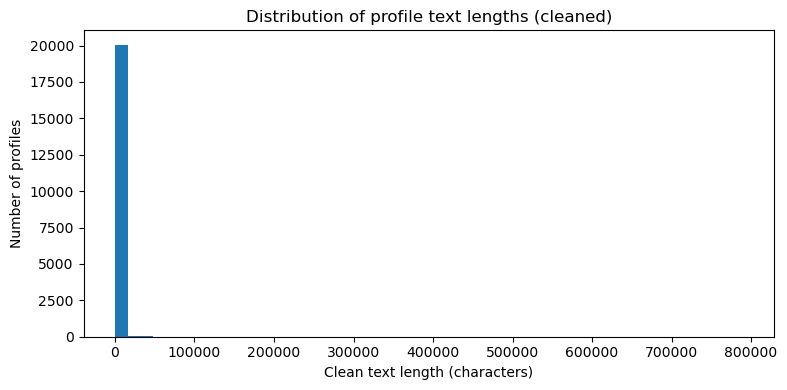

95th percentile chars_clean: 2266.5999999999985
99th percentile chars_clean: 8134.680000000015


In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(text_df["chars_clean"], bins=50)
plt.xlabel("Clean text length (characters)")
plt.ylabel("Number of profiles")
plt.title("Distribution of profile text lengths (cleaned)")
plt.tight_layout()
plt.show()

print("95th percentile chars_clean:", np.percentile(text_df["chars_clean"], 95))
print("99th percentile chars_clean:", np.percentile(text_df["chars_clean"], 99))

### Long profile outliers (top 25)

In [ ]:
long_outliers = text_df.sort_values("chars_clean", ascending=False).head(25)
long_outliers

,reference,name,link,n_value_strings,chars_raw,chars_clean,has_percent_markup,has_dollar_markup,has_amp_markup
19285,12000,THOMAS de Aquino,/individus/12000-thomasdeaquino,6794,800983,789190,1,1,1
1542,50875,AEGIDIUS Romanus,/individus/50875-aegidiusromanus,3632,317822,312431,1,1,1
10137,54530,HUGO de Sancto Victore,/individus/54530-hugodesanctovictore,4416,192330,189612,1,1,1
2410,1533,BONAVENTURA de Bagnoregio,/individus/1533-bonaventuradebagnoregio,3947,174205,171709,1,1,1
488,385,ALBERTUS Magnus,/individus/385-albertusmagnus,2895,156803,154565,1,1,1
19952,52376,VINCENTIUS Belvacensis,/individus/52376-vincentiusbelvacensis,985,134491,132525,1,1,1
17328,58754,ROBERTUS Grosseteste,/individus/58754-robertusgrosseteste,2615,133420,131631,1,1,1
12654,51944,NICOLAUS de Lyra,/individus/51944-nicolausdelyra,2031,133335,127771,1,1,1
6010,23409,GUILLELMUS Peraldus,/individus/23409-guillelmusperaldus,1795,99856,98673,1,1,1
350,16804,ARNALDUS de Villanova,/individus/16804-arnaldusdevillanova,2304,100766,98476,1,1,1


### Export: text length report

In [ ]:
text_csv = os.path.join(OUTPUT_DIR, "text_length_and_markup_report.csv")
text_df.to_csv(text_csv, index=False)
print("Wrote:", text_csv)

Wrote: eda_outputs\text_length_and_markup_report.csv


## 9) Date consistency checks

We scan `meta.dates` across the whole dataset and flag:
- years with unusual digit lengths (not 4 digits)
- years outside expected domain bounds
- interval inversions (start > end)

In [ ]:
def iter_meta_dates(rec: Dict[str, Any]) -> Iterator[Tuple[str, Dict[str, Any]]]:
    # Yield (path, date_object) for each entry in any 'meta.dates' list.
    def walk(obj: Any, path: str = ""):
        if isinstance(obj, dict):
            if "dates" in obj and isinstance(obj["dates"], list):
                for d in obj["dates"]:
                    if isinstance(d, dict):
                        yield (path, d)
            for k, v in obj.items():
                new_path = f"{path}.{k}" if path else k
                yield from walk(v, new_path)
        elif isinstance(obj, list):
            for it in obj:
                yield from walk(it, path + "[]")
    yield from walk(rec, "")

def extract_year(endpoint: Any) -> Optional[int]:
    if isinstance(endpoint, dict) and isinstance(endpoint.get("date"), int):
        return endpoint["date"]
    return None

date_rows = []
for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Date scan"):
    ref = rec.get("reference")
    name = get_first_name(rec)
    link = rec.get("link")

    for path, d in iter_meta_dates(rec):
        y1 = extract_year(d.get("startDate"))
        y2 = extract_year(d.get("endDate"))
        date_rows.append({
            "reference": ref,
            "name": name,
            "link": link,
            "path": path,
            "type": d.get("type"),
            "start_year": y1,
            "end_year": y2,
            "start_len": len(str(abs(y1))) if isinstance(y1, int) else None,
            "end_len": len(str(abs(y2))) if isinstance(y2, int) else None,
            "start_out_of_bounds": int(isinstance(y1, int) and not (EXPECTED_YEAR_MIN <= y1 <= EXPECTED_YEAR_MAX)),
            "end_out_of_bounds": int(isinstance(y2, int) and not (EXPECTED_YEAR_MIN <= y2 <= EXPECTED_YEAR_MAX)),
            "interval_inverted": int(isinstance(y1, int) and isinstance(y2, int) and y1 > y2),
        })

dates_df = pd.DataFrame(date_rows)

print("Total meta date entries:", len(dates_df))
dates_df.head()

Date scan:   0%|          | 0/20149 [00:00<?, ?it/s]

Total meta date entries: 131338


,reference,name,link,path,type,start_year,end_year,start_len,end_len,start_out_of_bounds,end_out_of_bounds,interval_inverted
0,15657,ANCELINUS Galli,/individus/15657-ancelinusgalli,identity.datesOfActivity[].meta,INTERVAL,1435.0,1435.0,4.0,4.0,0,0,0
1,15657,ANCELINUS Galli,/individus/15657-ancelinusgalli,curriculum.university[].meta,INTERVAL,1435.0,1435.0,4.0,4.0,0,0,0
2,15657,ANCELINUS Galli,/individus/15657-ancelinusgalli,curriculum.grades[].meta,BEFORE,NaN,NaN,NaN,NaN,0,0,0
3,15657,ANCELINUS Galli,/individus/15657-ancelinusgalli,curriculum.grades[].meta,SIMPLE,NaN,NaN,NaN,NaN,0,0,0
4,948,ARNALDUS Dordraci,/individus/948-arnaldusdordraci,identity.datesOfActivity[].meta,INTERVAL,1485.0,1486.0,4.0,4.0,0,0,0


### Investigate suspicious dates

In [ ]:
odd_digit = dates_df[
    ((dates_df["start_len"].notna()) & (dates_df["start_len"] != 4)) |
    ((dates_df["end_len"].notna()) & (dates_df["end_len"] != 4))
].sort_values(["start_len","end_len"], ascending=False)

print("Odd digit-length dates:", len(odd_digit))

out_of_bounds = dates_df[(dates_df["start_out_of_bounds"] == 1) | (dates_df["end_out_of_bounds"] == 1)]
print("Out-of-bounds meta dates:", len(out_of_bounds))

inverted = dates_df[dates_df["interval_inverted"] == 1]
print("Inverted intervals:", len(inverted))

odd_digit.head(30)

Odd digit-length dates: 56
Out-of-bounds meta dates: 123
Inverted intervals: 83


,reference,name,link,path,type,start_year,end_year,start_len,end_len,start_out_of_bounds,end_out_of_bounds,interval_inverted
6627,53852,ASTORGIUS Glanderie,/individus/53852-astorgiusglanderie,ecclesiasticalCareer.secularPosition[].meta,INTERVAL,14487.0,1520.0,5.0,4.0,1,0,1
17203,16648,BRANDANUS I de Castiglione,/individus/16648-brandanusidecastiglione,professionalCareer.representation[].meta,INTERVAL,14111.0,1412.0,5.0,4.0,1,0,1
36368,2632,GALTERIUS de Marvis,/individus/2632-galteriusdemarvis,ecclesiasticalCareer.popFunctions[].meta,INTERVAL,12131.0,1233.0,5.0,4.0,1,0,1
56233,55914,GUILLELMUS de Besza,/individus/55914-guillelmusdebesza,professionalCareer.royalAdministration[].meta,INTERVAL,21404.0,1435.0,5.0,4.0,1,0,1
66798,5161,HUGO Rogerii 1,/individus/5161-hugorogerii1,ecclesiasticalCareer.secularPosition[].meta,INTERVAL,11362.0,1363.0,5.0,4.0,1,0,1
87333,58418,NICOLAUS de Gorran,/individus/58418-nicolausdegorran,curriculum.universityCollege[].meta,INTERVAL,12870.0,1295.0,5.0,4.0,1,0,1
96958,13603,PETRUS Guillelmi de Vireyo,/individus/13603-petrusguillelmidevireyo,curriculum.universityCollege[].meta,INTERVAL,14521.0,1453.0,5.0,4.0,1,0,1
43562,55355,GEORGIUS de Vico,/individus/55355-georgiusdevico,ecclesiasticalCareer.secularPosition[].meta,INTERVAL,14621.0,NaN,5.0,NaN,1,0,0
10667,50949,ARTHURUS de Bourbon,/individus/50949-arthurusdebourbon,ecclesiasticalCareer.secularPosition[].meta,INTERVAL,1465.0,14741.0,4.0,5.0,0,1,0
33850,21593,GERARDUS Boniolis,/individus/21593-gerardusboniolis,identity.datesOfActivity[].meta,INTERVAL,1447.0,14501.0,4.0,5.0,0,1,0


### Export: date anomaly reports

In [ ]:
dates_csv = os.path.join(OUTPUT_DIR, "all_meta_dates.csv")
odd_digit_csv = os.path.join(OUTPUT_DIR, "odd_digit_dates.csv")
oob_csv = os.path.join(OUTPUT_DIR, "out_of_bounds_dates.csv")
inv_csv = os.path.join(OUTPUT_DIR, "inverted_intervals.csv")

dates_df.to_csv(dates_csv, index=False)
odd_digit.to_csv(odd_digit_csv, index=False)
out_of_bounds.to_csv(oob_csv, index=False)
inverted.to_csv(inv_csv, index=False)

print("Wrote:", dates_csv)
print("Wrote:", odd_digit_csv)
print("Wrote:", oob_csv)
print("Wrote:", inv_csv)

Wrote: eda_outputs\all_meta_dates.csv
Wrote: eda_outputs\odd_digit_dates.csv
Wrote: eda_outputs\out_of_bounds_dates.csv
Wrote: eda_outputs\inverted_intervals.csv


## 10) `activityMediane` sanity checks

`extras.activityMediane` is handy for timeline analyses, but can be impacted by date parsing artifacts.
We flag outliers outside `[EXPECTED_YEAR_MIN, EXPECTED_YEAR_MAX]`.

In [ ]:
activity = index_df[["reference","name","link","activityMediane"]].copy()

missing_activity = activity["activityMediane"].isna().sum()
print("Missing activityMediane:", missing_activity)

oob_activity = activity[
    activity["activityMediane"].notna() &
    ~activity["activityMediane"].between(EXPECTED_YEAR_MIN, EXPECTED_YEAR_MAX)
].sort_values("activityMediane", ascending=False)

print("Out-of-bounds activityMediane:", len(oob_activity))
oob_activity.head(30)

Missing activityMediane: 104
Out-of-bounds activityMediane: 23


,reference,name,link,activityMediane
18284,13692,SIMON de Fouquereulles,/individus/13692-simondefouquereulles,7981.0
5185,21593,GERARDUS Boniolis,/individus/21593-gerardusboniolis,7974.0
5516,53059,GUILLELMUS Guerini,/individus/53059-guillelmusguerini,7702.0
8970,50061,GUIDO de Calvomonte,/individus/50061-guidodecalvomonte,7393.0
13259,51925,NICOLAUS Beyart,/individus/51925-nicolausbeyart,2221.0
4212,54095,DURANDUS de Anglia,/individus/54095-durandusdeanglia,1099.0
78,55329,ANCELLUS,/individus/55329-ancellus,1096.0
4057,54092,DROCO Gramaticus,/individus/54092-drocogramaticus,1092.0
8755,52757,GALFREDUS Wintoniensis,/individus/52757-galfreduswintoniensis,1088.0
11673,58667,MANEGOLDUS de Lautenbach,/individus/58667-manegoldusdelautenbach,1086.0


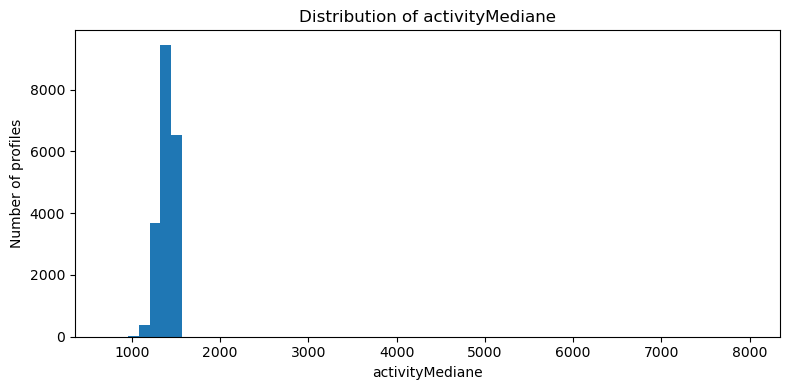

In [ ]:
plt.figure(figsize=(8, 4))
vals = activity["activityMediane"].dropna().astype(float)
plt.hist(vals, bins=60)
plt.xlabel("activityMediane")
plt.ylabel("Number of profiles")
plt.title("Distribution of activityMediane")
plt.tight_layout()
plt.show()

In [ ]:
activity_csv = os.path.join(OUTPUT_DIR, "activityMediane_outliers.csv")
oob_activity.to_csv(activity_csv, index=False)
print("Wrote:", activity_csv)

Wrote: eda_outputs\activityMediane_outliers.csv


## 11) Value-level profiling (categorical fields)

We profile common “categorical” attributes:
- `identity.gender`
- `identity.status`

This helps detect unexpected values and normalization needs.

In [ ]:
def extract_values(rec: Dict[str, Any], path: List[str]) -> List[str]:
    # Extract list of 'value' strings at a path like ["identity","gender"].
    obj: Any = rec
    for k in path:
        if not isinstance(obj, dict) or k not in obj:
            return []
        obj = obj[k]
    if isinstance(obj, list):
        out: List[str] = []
        for it in obj:
            if isinstance(it, dict) and isinstance(it.get("value"), str):
                out.append(strip_studium_markup(it["value"]))
        return out
    return []

gender_counter = Counter()
status_counter = Counter()

for rec in tqdm(iter_jsonl(INPUT_JSONL, sample_n=SAMPLE_N), total=(SAMPLE_N or total_lines), desc="Categoricals"):
    for g in extract_values(rec, ["identity","gender"]):
        gender_counter[g] += 1
    for s in extract_values(rec, ["identity","status"]):
        status_counter[s] += 1

print("Gender values:")
display(pd.DataFrame(gender_counter.most_common(), columns=["gender","count"]).head(20))

print("\nStatus values:")
display(pd.DataFrame(status_counter.most_common(), columns=["status","count"]).head(20))

Categoricals:   0%|          | 0/20149 [00:00<?, ?it/s]

Gender values:


,gender,count
0,male,19980
1,female,169



Status values:


,status,count
0,Maître,7511
1,Étudiant,4378
2,Incertain,3172
3,Gradué,2798
4,Extérieur,1704
5,Suppôt,586


In [ ]:
gender_csv = os.path.join(OUTPUT_DIR, "identity_gender_distribution.csv")
status_csv = os.path.join(OUTPUT_DIR, "identity_status_distribution.csv")

pd.DataFrame(gender_counter.most_common(), columns=["gender","count"]).to_csv(gender_csv, index=False)
pd.DataFrame(status_counter.most_common(), columns=["status","count"]).to_csv(status_csv, index=False)

print("Wrote:", gender_csv)
print("Wrote:", status_csv)

Wrote: eda_outputs\identity_gender_distribution.csv
Wrote: eda_outputs\identity_status_distribution.csv


## 12) Link checks

We validate that:
- `link` exists
- looks like a profile path (e.g. `/individus/...`)

In [ ]:
bad_links = index_df[
    index_df["link"].isna() |
    ~index_df["link"].astype(str).str.startswith("/individus/")
]
print("Bad/missing links:", len(bad_links))
bad_links.head(20)

Bad/missing links: 0


,reference,name,title,link,activityMediane,has_identity,has_curriculum,has_bibliography,has_origin,has_ecclesiasticalCareer,has_professionalCareer,has_relationalInsertion,has_textualProduction,has_assets,has_politicalCareer,has_travels,has_commissions,has_orality,has_distinctiveSign,has_otherActivities


In [ ]:
bad_links_csv = os.path.join(OUTPUT_DIR, "bad_links.csv")
bad_links.to_csv(bad_links_csv, index=False)
print("Wrote:", bad_links_csv)

Wrote: eda_outputs\bad_links.csv
